# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.138649,False,0.036420
1,1.856474,True,7.442506
2,-0.990596,True,3.599313
3,1.203419,True,6.996174
4,-0.062685,False,-1.244184
...,...,...,...
995,0.924591,True,8.395787
996,1.904014,True,7.061856
997,0.386262,False,0.712719
998,0.769776,True,7.633632


<Axes: xlabel='v0'>

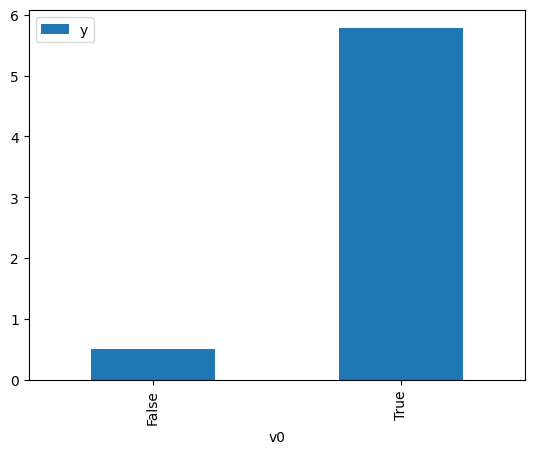

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

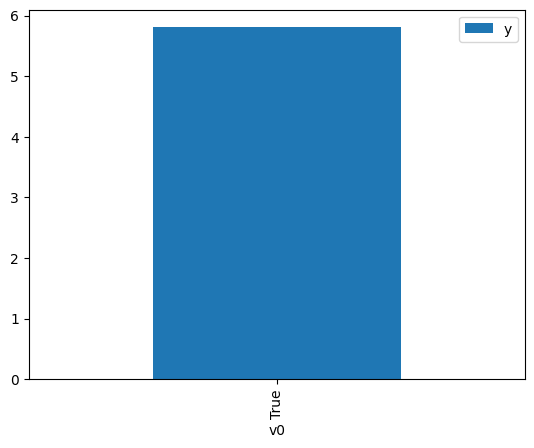

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.441057,False,0.933512,0.274681,3.640581
1,1.160393,False,1.391324,0.083835,11.928165
2,-0.571954,False,-2.177065,0.736763,1.357288
3,-0.654082,False,-1.189069,0.766987,1.303803
4,0.531831,False,-1.192929,0.240446,4.158934
...,...,...,...,...,...
995,-0.242818,False,0.527535,0.593710,1.684323
996,0.886562,False,2.131700,0.135796,7.364007
997,0.441057,False,0.933512,0.274681,3.640581
998,1.714248,False,2.830494,0.029744,33.620529


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.745065,True,6.780098,0.827964,1.207781
1,-1.211779,True,4.477512,0.091741,10.900255
2,0.124096,True,4.746405,0.585442,1.708112
3,-1.211779,True,4.477512,0.091741,10.900255
4,0.711163,True,5.197645,0.818219,1.222166
...,...,...,...,...,...
995,0.038297,True,5.151240,0.543822,1.838836
996,1.567734,True,7.701413,0.960670,1.040940
997,1.467196,True,7.535896,0.952444,1.049930
998,1.202094,True,6.318576,0.922276,1.084274


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          1.397e+04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:12:02   Log-Likelihood:                         -1441.3
No. Observations:                1000   AIC:                                      2887.
Df Residuals:                     998   BIC:                                      2897.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4869      0.039     37.955      0.000       1.410       1.564
x2             5.0359      0.054     93.425      0.000       4.930       5.142
==============================================================================
Omnibus:                        5.632   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                4.568
Skew:                          -0.069   Prob(JB):                        0.102
Kurtosis:                       2.699   Cond. No.                         2.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""